In [1]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
import yaml

# Plots

This notebook collects the script for the plots.

## Decay constant from the echo peaks

We measure the physical dephasing time from the height and time position of the echo peaks.

In [2]:
file = 'echo_results/echo_decay.yaml'

In [7]:
eta = 4e-4

In [3]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'ref', 'time'])

In [11]:
time = np.array(data_loaded['time'])
ref = np.array(data_loaded['ref'])
echo = data_loaded['echo']

In [12]:
ref_val = '0.5ps'
max_ind = np.argmax(echo[ref_val])
ampl = echo[ref_val][max_ind]
time_eta = time[max_ind:]
exp_decay = ampl*np.exp(-eta*(time_eta-time_eta[0]))

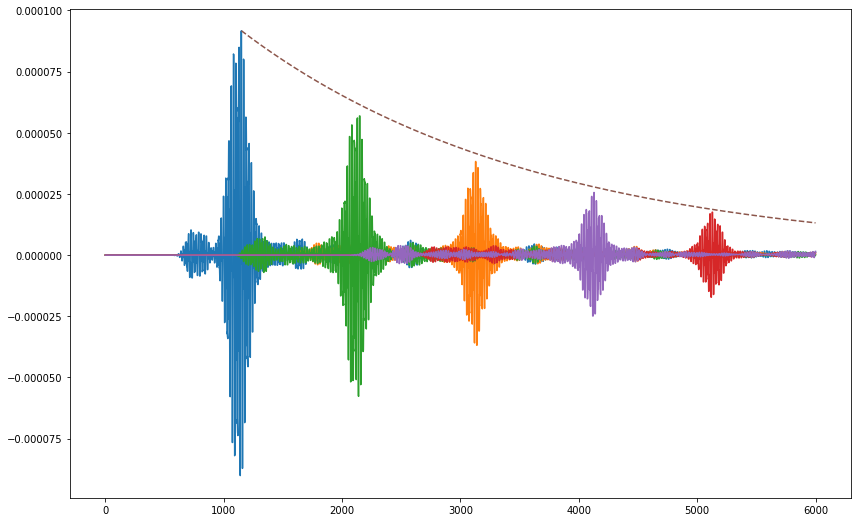

In [14]:
plt.figure(figsize=(14,9))
for t in echo:
    plt.plot(time,echo[t],label='echo_'+t)
plt.plot(time_eta,exp_decay,linestyle='--')

In [ ]:
######################################################

In [ ]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],dos.dos[0][1], label='JDOS')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('JDOS',size=label_size)
ax1.set_xlim(1,3.5)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

